In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

#For statistics
from scipy import stats
#For DataProcessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

#For Machine Learning
from sklearn.model_selection import train_test_split
from sklearn import linear_model

#For Neural Network with TensorFlow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from __future__ import absolute_import, division, print_function

import pathlib
import os
print(os.listdir("../input"))

print('TensorFlow version is:',tf.__version__)

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv', 'data_description.txt']
TensorFlow version is: 1.12.0


# The minimal data preprocessing from my other kernel:

In [2]:
#Read the data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
#print the dtypes in train to see how we can separate the quantitative from the qualitative
print("All dtypes in train are",train.dtypes.unique())

#separate the data into quantitative and qualitative
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
target = 'SalePrice'
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

#For categorical data, we assign a value 'MISSING' to it to make it a new category
for c in qualitative:
    if train[c].isnull().any():
        train[c] = train[c].fillna('MISSING')
    if test[c].isnull().any():
        test[c] = test[c].fillna('MISSING')


def rank_qual(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering['val'].values
    ordering.pop('val')
    ordering['spmean'] = frame[[feature,'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values(by = 'spmean')
    ordering['rank'] = range(1,ordering.shape[0]+1)
    return ordering

def encode_rank(df,feature,ordering):
    """encode a categoraical feature based on rank
        the encoded feature becomes a new column featire+'_E' added to df
    df: DataFrame, the DataFrame with categorical feature 
    feature: str, the column name to encode
    ordering: DataFrame, a dictionary in df form that maps categoraical values to ranks
    
    """
    ordering = ordering['rank'].to_dict()
    for f_val, rank in ordering.items():
        df.loc[df[feature] == f_val, feature+'_E'] = rank
        
qual_encoded=[]        
for feature in qualitative:
    
    ordering = rank_qual(train,feature)

    encode_rank(train,feature,ordering)
    encode_rank(test,feature,ordering)
    qual_encoded.append(feature +'_E') 
    






# def encode(frame, feature):
#     ordering = pd.DataFrame()
#     ordering['val'] = frame[feature].unique()
#     ordering.index = ordering['val']
#     ordering['spmean'] = frame[[feature,target]].groupby(feature).mean()[target]
#     ordering = ordering.sort_values(by = 'spmean')
#     ordering['rank'] = range(1,ordering.shape[0]+1)
#     ordering = ordering['rank'].to_dict()
#     for f_val, rank in ordering.items():
#         frame.loc[frame[feature] == f_val, feature+'_E'] = rank
# qual_encoded=[]
# for f in qualitative:
#     encode(train,f)
#     qual_encoded.append(f+'_E') 
    
#the error used by this competition is the root-mean-squared error of log
def error(actual, hat):
    return np.sqrt(np.sum(np.square(np.log(actual)-np.log(hat)))/len(actual))




All dtypes in train are [dtype('int64') dtype('O') dtype('float64')]


## We have handled the categorical missing data and encoded them in both training and testing sets. But let's look at the bar plot of missing columns again before we move on!

All missing data in training set are quantitative. Well done!
Some qual_encoded in test is still missing. Check it!


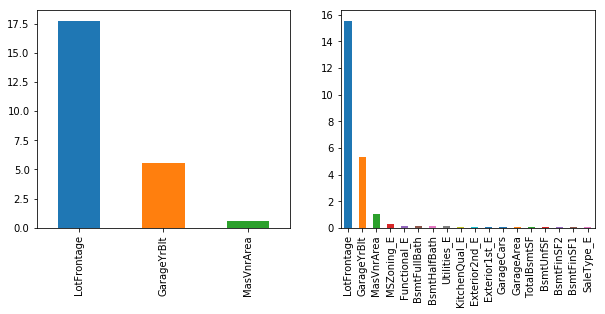

In [3]:
#Check the missing
def barplot_missing(df):
    #barplot and list the total number and percentage
    total = df.isnull().sum(axis=0)
    percent = 100*total /df.isnull().count()
    missing = pd.concat([total, percent], axis =1, keys = ['Total','Percent(%)'])
    missing = missing[missing['Total']>0]
    missing = missing.sort_values(by='Total', ascending=False)
    missing['Percent(%)'].plot.bar()
    return missing
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
missing = barplot_missing(train)
print('All missing data in training set are quantitative. Well done!' if(missing.index).all() in quantitative else 'Some qual_encoded in train is still missing. Check it!')
plt.subplot(1,2,2)
missing = barplot_missing(test)
print('All missing data in testing set are quantitative. Well done!' if (missing.index).all() in quantitative else 'Some qual_encoded in test is still missing. Check it!')

## To our surprise, although the traing set is properly encoded, the testing set does still have missing data in encoded columns!  Let's  see what they are.

In [4]:
#Check the qual_encoded columns in testing data
missing_qual_E = [ c for c in missing.index if c in qual_encoded]
missing.loc[missing_qual_E]

,Total,Percent(%)
MSZoning_E,4,0.27416
Functional_E,2,0.13708
Utilities_E,2,0.13708
KitchenQual_E,1,0.06854
Exterior2nd_E,1,0.06854
Exterior1st_E,1,0.06854
SaleType_E,1,0.06854


## We notice that numbers for the missing encoded data are really small. It's very likely they are missing qualitative data before encoding. But we have handled them with assigning 'MISSING' to the qualitative values! Let's find out what it is.

In [5]:
#Check MSZoning column to see if the unique values in training and testing datasets are the same
print('Unique values in training data for MSZoning:',train['MSZoning'].unique())
print('Unique values in test data for MSZoning:',test['MSZoning'].unique())
#check to see if there's any NaN in train and test
print(train['MSZoning'].isnull().any(),test['MSZoning'].isnull().any())

Unique values in training data for MSZoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']
Unique values in test data for MSZoning: ['RH' 'RL' 'RM' 'FV' 'C (all)' 'MISSING']
False False


Now it's clear where these small fraction of missing data are from. They are complete in the training set, but are missed in the testing set. 
### In this case, we decide to set the encoded values to be the average for them.

In [6]:
#Assign avg rank to each missing encoded feature
mean = train[missing_qual_E].mean()
for c in missing_qual_E:
    avg = mean[c]
    test.loc[:,c]=test[c].fillna(avg)


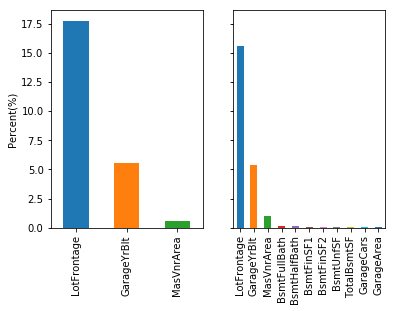

In [7]:
ax1 = plt.subplot(1,2,1)
missing_num_train=barplot_missing(train)
plt.ylabel('Percent(%)')

plt.subplot(1,2,2,sharey=ax1)
missing_num_test= barplot_missing(test)


# The three numeric features missing in the traning set has nonnegligible fraction, especially the LotFrontage. We should deal with these three more carefully than assigning zeros to them

# 1.For LotFrontage that has ~15% missing data, we would like to see whether they're missing. We know it should be related to LotArea.

## First we would like to see if a missing LotFrontage means no lot. We check if there's any row that has zero LotArea   

In [8]:
#check if any LotArea is zero
print(np.where(train['LotArea']==0))
print(np.where(test['LotArea']==0))

#check the min value of LotArea, LotFrontage
print('The min of LotArea/LotFrontage in train is:' ,train['LotArea'].min(),'/', train['LotFrontage'].min(),'\n',
'The min of LotAreaLot/Frontage in test is:',test['LotArea'].min(),'/', test['LotFrontage'].min())
#train.loc[np.where(train['LotArea']==0)[0],['LotArea','LotFrontage']]

(array([], dtype=int64),)
(array([], dtype=int64),)
The min of LotArea/LotFrontage in train is: 1300 / 21.0 
 The min of LotAreaLot/Frontage in test is: 1470 / 21.0


## It seems every house has a parking lot. Therefore we assume the missing LotFrontage are missing data because their corresponding LotArea is not missing

In [9]:
def intersection(s1,s2):
    return list(set(s1)&set(s2))

LotArea_Positive = np.where(train['LotArea']>0)
LotFrontage_missing = np.where(train['LotFrontage'].isnull())

condition = intersection(LotArea_Positive[0],LotFrontage_missing[0])
print('The number of rows that  LotArea>0 but LotFrontage is missing is:',len(condition) )
#train.loc[condition, ['LotArea','LotFrontage']]

The number of rows that  LotArea>0 but LotFrontage is missing is: 259


## Our strategy is to approximate the LotFrontage with LotArea. Let's plot out their relations and also look at their relations with SalePrice.

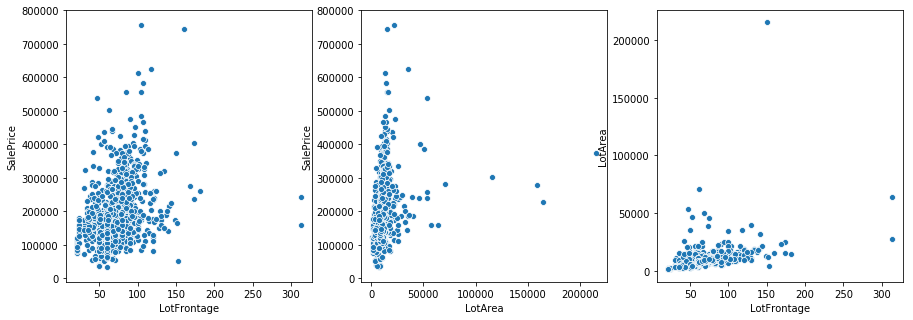

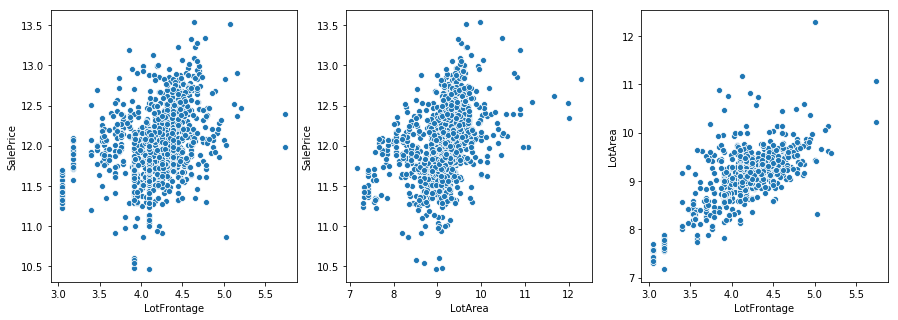

In [10]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,3,1)
sns.scatterplot(train['LotFrontage'],train['SalePrice'])

ax2 =plt.subplot(1,3,2,sharey=ax1)
sns.scatterplot(train['LotArea'],train['SalePrice'])


ax3= plt.subplot(1,3,3)
sns.scatterplot(train['LotFrontage'],train['LotArea'])

plt.figure(figsize=(15,5))
ax4 = plt.subplot(1,3,1)
sns.scatterplot(np.log(train['LotFrontage']),np.log(train['SalePrice']))

ax5 =plt.subplot(1,3,2)
sns.scatterplot(np.log(train['LotArea']),np.log(train['SalePrice']))


ax6= plt.subplot(1,3,3)
sns.scatterplot(np.log(train['LotFrontage']),np.log(train['LotArea']))


![](http://)### We notice significant linear realation between the log of LotArea and LotFrontage. This agrees with our knowledge of area = length**2
### However to be more careful, let's exam all other variable with keywords 'Lot' to validate this simple assumption


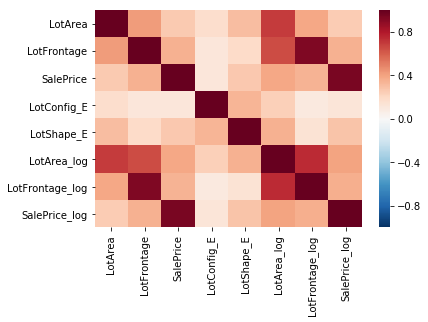

In [11]:
fr = pd.concat([train['LotArea'], train['LotFrontage'],
                train['SalePrice'],
                train['LotConfig_E'],train['LotShape_E'],
                train['LotConfig'], train['LotShape']],axis=1)
fr['LotArea_log'] = np.log(train['LotArea'])
fr['LotFrontage_log'] = np.log(train['LotFrontage'])
fr['SalePrice_log'] = np.log(train['SalePrice'])
numeric = ['LotArea','LotFrontage','SalePrice','LotConfig_E','LotShape_E','LotArea_log','LotFrontage_log','SalePrice_log']
fr[numeric].head()
corr = fr[numeric].corr()
sns.heatmap(corr, cmap='RdBu_r',vmin=-1,vmax=1)


we see that only LotArea_log show significant linear relation with LotFrontage_log

## We use linear regression to fit LotFrontage_log. 
### We have the option to combine both training set and testing set.

In [12]:
df1=train[['LotArea','LotFrontage','LotConfig','LotShape']].dropna()
df2=test[['LotArea','LotFrontage','LotConfig','LotShape']].dropna()

df1['LotArea_log'] = np.log(df1['LotArea'])
df2['LotArea_log'] = np.log(df2['LotArea'])

df1['LotFrontage_log'] = np.log(df1['LotFrontage'])
df2['LotFrontage_log'] = np.log(df2['LotFrontage'])
df = pd.concat(
[df1,df2]
,axis=0,ignore_index=True )

df.tail()

,LotArea,LotFrontage,LotConfig,LotShape,LotArea_log,LotFrontage_log
2428,1936,21.0,Inside,Reg,7.568379,3.044522
2429,1894,21.0,Inside,Reg,7.546446,3.044522
2430,20000,160.0,Inside,Reg,9.903488,5.075174
2431,10441,62.0,Inside,Reg,9.253496,4.127134
2432,9627,74.0,Inside,Reg,9.172327,4.304065


Regression of LotFrontage with LotArea

Coefficients: [[0.55120731]]
R^2: 0.5871939382688669


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


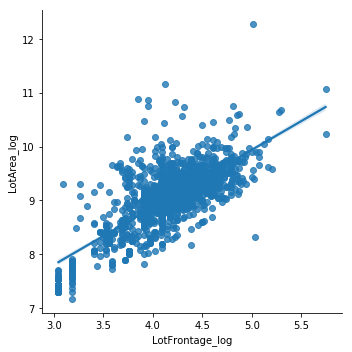

In [13]:

regr = linear_model.LinearRegression()
X = df['LotArea_log'].values.reshape(-1,1)
Y = df['LotFrontage_log'].values.reshape(-1,1)
# print(X.reshape(-1,1).shape)
# print(Y)
regr.fit(X,Y)
print('Coefficients:',regr.coef_)
print('R^2:',regr.score(X,Y))

sns.lmplot(data=df,  x='LotFrontage_log', y='LotArea_log',
           truncate=True,fit_reg=True)


We see that the coefficient is close  to .5
We can now assign values to the missing LotFrontage with the linear regression

In [14]:

def fill_with_lm(regr,df,missing_feature, expl_vars,if_log_log=True):
    """
    missing_feature: str, the name of the missing feature to fill with linear model
    expl_vars: list of str, the 
    """
    #in training set
    missing_rows = np.where(df[missing_feature].isnull())[0]
    x = df.loc[missing_rows,expl_vars]
    if if_log_log:
        x = np.log(x).values

    #assign the values inplace
    try:
        y = regr.predict(x.reshape(-1,1))
        if if_log_log:
            y=np.exp(y)
        df.loc[missing_rows,missing_feature] = y
        print('Missing data in',missing_feature,'is fileed with linear model.')
    except:
        print('No filling is done.')

#fill the data with linear model
fill_with_lm(regr,train,'LotFrontage',['LotArea'])
fill_with_lm(regr,test,'LotFrontage',['LotArea'])


#fill_with_lm(regr,train,'LotFrontage',['LotArea'])



Missing data in LotFrontage is fileed with linear model.
Missing data in LotFrontage is fileed with linear model.


## 2.For GarageYrBlt, we suspect the missing data mean there's no garage at all. We check this by plotting out the GarageArea distribution and also compare the rows where GarageArea=0 with rows  where GarageYrBlt = NaN.

training set has no missing GarageArea
training set has missing GarageArea
In testing set:
78 rows have GarageYrBlt is NaN.
76 rows have GarageArea ==0.


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


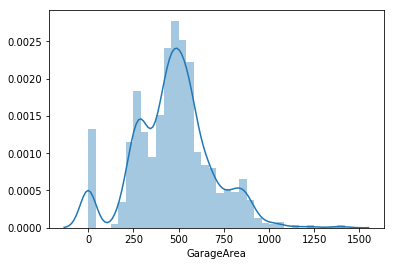

In [15]:
sns.distplot(train['GarageArea'])
print('training set has no missing GarageArea'
      if np.array_equal(np.where(train['GarageYrBlt'].isnull()),  np.where(train['GarageArea']==0))
     else 'training set has missing GarageArea')
print('testing set has no missing GarageArea'
      if np.array_equal(np.where(test['GarageYrBlt'].isnull()),  np.where(test['GarageArea']==0))
          else'training set has missing GarageArea')
print('In testing set:')
yr_is_missing=np.where(test['GarageYrBlt'].isnull())
area_is_zero = np.where(test['GarageArea']==0)
area_is_not_zero = np.where(test['GarageArea']!=0)

print(len(yr_is_missing[0]),'rows have GarageYrBlt is NaN.')
print(len(area_is_zero[0]),'rows have GarageArea ==0.')


## Our suspection is mostly confrimed, but there are two anomalies. We identified two rows that have garages but their GarageYrBlt is unknown. We assume it is missing.

## For these two data we decide to set their GarageYrBlt to the average value of the training set. Because they do have a Garage, but the data of year built is missing.

## We set all others to 0 to account for the fact that it has no garage. This approach should be fine with neural network because the model can adapt to nonlinear behavior. Setting them to zero should amount to similar effect of setting another one-hot feature.

# We will hande setting to zero altogether in the end

In [16]:
#the index in testing data where they do have a garage but GarageYrBlt is unknown
yr_unknown_index=[i for i  in yr_is_missing[0] if i in area_is_not_zero[0]]
Yr_avg = train['GarageYrBlt'].mean()
test.loc[yr_unknown_index, 'GarageYrBlt'] = Yr_avg

#train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)
# test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)

# 3.For MasVnrArea, its distribution shows more than 50% of zeros. 
## We handle this with a more simple way by assinging it to the most probable value 0 because the loss fraction is very small.


count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64
count    1444.000000
mean      100.709141
std       177.625900
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1290.000000
Name: MasVnrArea, dtype: float64


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


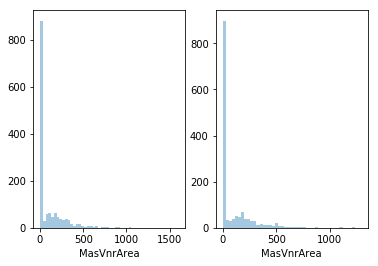

In [17]:
print(train['MasVnrArea'].describe())
plt.subplot(1,2,1)
sns.distplot(train['MasVnrArea'].dropna(),kde=False)
print(test['MasVnrArea'].describe())
plt.subplot(1,2,2)
sns.distplot(test['MasVnrArea'].dropna(),kde=False)

Handled the rest of the missing data in test


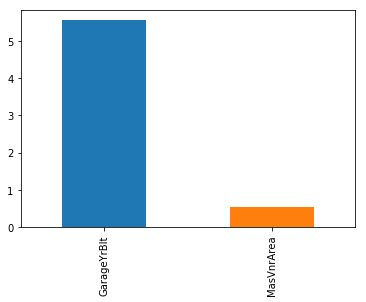

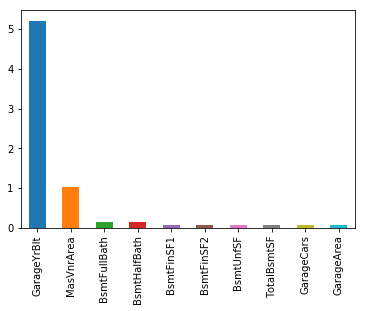

In [18]:
_ = barplot_missing(train)
plt.figure()
_ = barplot_missing(test)

In [19]:
missing_quant = [c for c in quantitative if test[c].isnull().any()]
handled = ['LotFrontage','GarageYrBlt','MasVnrArea']
#features in testing set that are still missing
unhandled = [f for f in missing_quant if f not in handled]
unhandled_mean = train[unhandled].mean()
unhandled_mean
for f in unhandled:
     test[f] = test[f].fillna(unhandled_mean[f])
        
test[unhandled].isnull().sum()
#we assign the average value to each of them 

BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
GarageCars      0
GarageArea      0
dtype: int64

In [20]:

#Choose quantitative and encoded qualitative data for training and testing
features = quantitative + qual_encoded
train_data = train[features]
test_data = test[features]




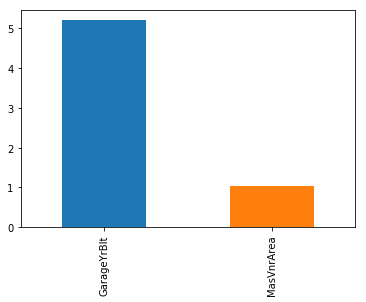

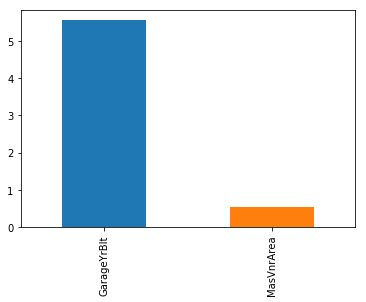

In [21]:
_=barplot_missing(test_data)
plt.figure()
_=barplot_missing(train_data)


In [22]:
#fill zeros to all 
train_data= train_data.fillna(0)
test_data= test_data.fillna(0)

In [23]:
#Normalize the data
train_stats = train_data.describe()
train_stats = train_stats.transpose()



def norm(x):
  return (x - train_stats.loc[:,'mean']) / train_stats.loc[:,'std']

normed_train_data = norm(train_data)
normed_test_data = norm(test_data)    

In [24]:
#check the normed data before training the model and giving predicition
print(normed_test_data.isnull().any().any(),
normed_train_data.isnull().any().any())

False False


# Build the model with tensorflow

In [25]:
train_dataset = normed_train_data
train_labels = train['SalePrice'] 
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_logarithmic_error',
                optimizer=optimizer,
                metrics=['mean_squared_logarithmic_error'])
  return model

#buili the model
model = build_model()



# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1500;

#set earlystop when val_loss is not improving, patienece is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(
  normed_train_data.values, train_labels.values,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[
              early_stop,
              PrintDot()])




....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


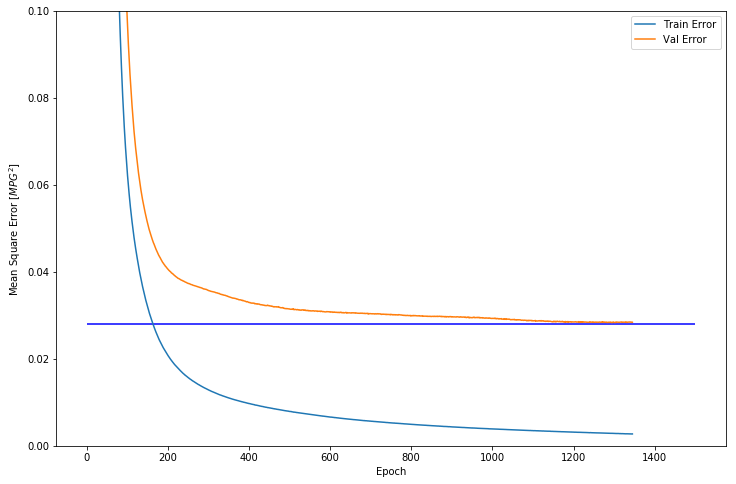

,val_loss,val_mean_squared_logarithmic_error,loss,mean_squared_logarithmic_error,epoch
1341,0.028426,0.028426,0.002735,0.002735,1341
1342,0.028458,0.028458,0.002733,0.002733,1342
1343,0.028429,0.028429,0.002724,0.002724,1343
1344,0.028389,0.028389,0.002722,0.002722,1344
1345,0.028404,0.028404,0.002727,0.002727,1345


In [27]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  

  
  plt.figure(figsize=(12,8))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_logarithmic_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_logarithmic_error'],
           label = 'Val Error')
  plt.ylim([0,.1])
  plt.legend()


plot_history(history)

plt.hlines(.028, 0, 1500,'b')
plt.show()
hist.tail()

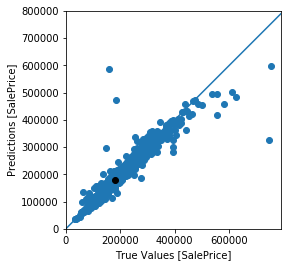

In [28]:
train_predictions = model.predict(normed_train_data).flatten()


plt.scatter(train_labels, train_predictions)
plt.xlabel('True Values [SalePrice]')
plt.ylabel('Predictions [SalePrice]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([0, 10**6], [0, 10**6])
plt.plot(train['SalePrice'].mean(),train['SalePrice'].mean(),'ko')

In [29]:
train_predictions = model.predict(normed_train_data).flatten()
print('the error on the training data is',error(train_predictions,train['SalePrice']))

the error on the training data is 0.08843731567172303


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


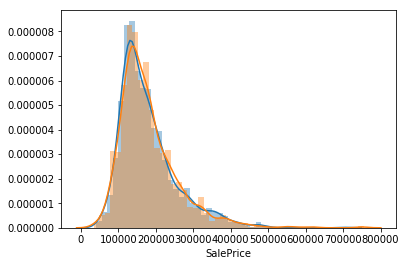

In [30]:
test_predictions = model.predict(normed_test_data).flatten()
sns.distplot(test_predictions)
sns.distplot(train['SalePrice'])

In [31]:
print(np.isnan(test_predictions).any())
len(test_predictions)

False


1459

In [32]:
submission = pd.read_csv("../input/sample_submission.csv")
submission['SalePrice'] = test_predictions
submission.isnull().any().any()
submission.to_csv("submission_1_030419.csv",index=False)